In [36]:
import numpy as np
from scipy import stats
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import curve_fit
from sklearn import preprocessing

In [2]:
def inverse_sample_decorator(dist):
    def wrapper(pnts, x_min=-100, x_max=100, n=1e5, **kwargs):
        x = np.linspace(x_min, x_max, int(n))
        cumulative = np.cumsum(dist(x, **kwargs))
        real_low = (cumulative/cumulative.max()).min()
        real_high = (cumulative/cumulative.max()).max()
        #print((cumulative/cumulative.max()).max(),(cumulative/cumulative.max()).min())
        f = interp1d(cumulative/cumulative.max(), x)
        return f(np.random.uniform(low=real_low, high=real_high, size=pnts))
    return wrapper

In [3]:
# First trying sampling from a simple gaussian distribution
@inverse_sample_decorator
def gauss(x, amp=1.0, mean=0.0, std=0.2):
    return amp*np.exp(-(x-mean)**2/std**2/2.0)

In [4]:
samples = gauss(5000, mean=20, std=0.8, x_min=19, x_max=21)

In [5]:
x = gauss(100000, mean=3.5, std=0.5)
#x = np.random.normal(3.5, 0.5, size=10000)

In [6]:
def gaussian(x, mean, amplitude, standard_deviation):
    return amplitude * np.exp( - ((x - mean) / standard_deviation) ** 2)

In [8]:
# Experimenting with Eq2
@inverse_sample_decorator
def f(x,ts=[1.1,1.2,1.3,1.4]):
    xx = x/(13)**0.5
    v = ts[0] * ((1-xx)**(ts[1])) * (xx**ts[2]) * (xx**(ts[3]*np.log(xx)))
    return v

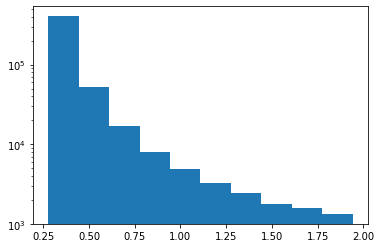

In [9]:
sampless = f(500000,ts=[1.1,1.2,1.3,1.4],x_min=1/(13**0.5),x_max=7/(13**0.5))

plt.hist(sampless, log=True)
plt.show()

[1.39246925 1.14706166 1.87799169 1.8149359 ]
[2.53909382 2.13079011 2.54611104 2.15334194]
[3.49274766 3.07429617 2.40224868 2.5874964 ]
[4.97425412 3.87826053 2.90591202 3.01334552]
[3.67546475 5.10765514 4.08969933 4.82743034]
[5.51210559 6.50713156 3.62299503 4.80225412]


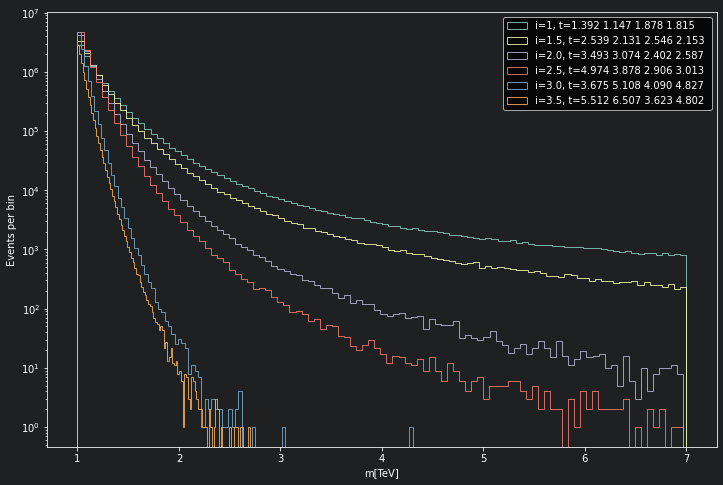

In [8]:
## Varing the theta values
## not sure the range that makes sense
#plt.style.use("dark_background")
#plt.figure(figsize=(12,8), facecolor='#1e2021')
#ax = plt.gca()
#ax.set_facecolor('#1e2021')
#i = 1
#while i != 4:
#    tsx = i * np.random.uniform(low=1, high=2, size=4)
#    print(tsx)
#    strFormat = len(tsx) * '{:.3f} '
#    ftsx = strFormat.format(*tsx)
#    samplex = f(10000000,ts=tsx,x_min=1/(13**0.5),x_max=7/(13**0.5)) 
#    samplex *= (13**0.5)
#    plt.hist(samplex, log=True, label="i={}, t={}".format(i,ftsx), histtype="step",
#             alpha=0.8, bins=100)
#    i += 0.5
#plt.xlabel("m[TeV]")
#plt.ylabel("Events per bin")
#plt.legend()
#plt.show()

In [10]:
samplesa = f(10000000,ts=[1.673,1.455,1.311,1.346],x_min=1/(13**0.5),x_max=7/(13**0.5))
samplesa *= (13**0.5)

In [11]:
samplesb = f(10000000,ts=[1.7,1.5,1.4,1.5],x_min=1/(13**0.5),x_max=7/(13**0.5))
samplesb *= (13**0.5)

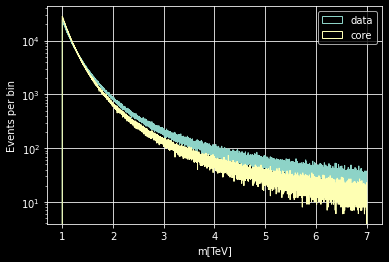

In [197]:
plt.style.use("dark_background")
(na, binsa, patchesa) = plt.hist(samplesa, log=True, bins=10000, label="data", histtype="step")
(nb, binsb, patchesb) = plt.hist(samplesb, log=True, bins=10000, label="core", histtype="step")
plt.grid()
plt.xlabel("m[TeV]")
plt.ylabel("Events per bin")
plt.legend()
plt.show()
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))

# rescale to 0,1
rna = scaler.fit_transform(na.reshape(-1, 1))
rnb = scaler.fit_transform(nb.reshape(-1, 1))

In [221]:
nbm = np.column_stack((nb, binsa[:nb.shape[0]]))
rnbm = np.column_stack((rnb, binsa[:rnb.shape[0]]))

In [321]:
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import tensorflow as tf
x_train, x_test, y_train, y_test = train_test_split(nbm, na, test_size=0.3)
rx_train, rx_test, ry_train, ry_test = train_test_split(rnbm, rna, test_size=0.3)

In [322]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(7000, 2)
(7000,)
(3000, 2)
(3000,)


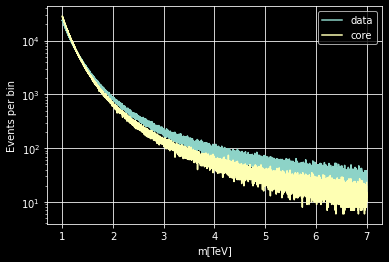

In [323]:
plt.yscale("log")
plt.plot(binsa[:na.shape[0]],na,label="data")
plt.plot(binsa[:nb.shape[0]],nb,label="core")
plt.grid()
plt.xlabel("m[TeV]")
plt.ylabel("Events per bin")
plt.legend()
plt.show()

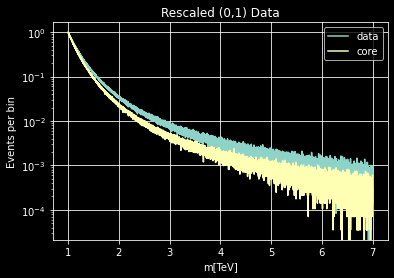

In [324]:
plt.yscale("log")
plt.title("Rescaled (0,1) Data")
plt.plot(binsa[:rna.shape[0]],rna,label="data")
plt.plot(binsa[:rnb.shape[0]],rnb,label="core")
plt.grid()
plt.xlabel("m[TeV]")
plt.ylabel("Events per bin")
plt.legend()
plt.show()

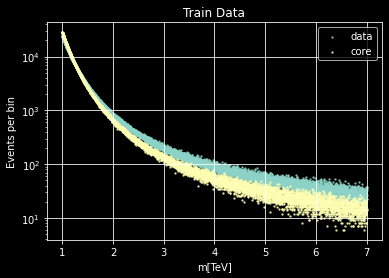

In [325]:
plt.yscale("log")
plt.title("Train Data")
plt.scatter(x_train[:y_train.shape[0],1],y_train,label="data",s=2,alpha=0.7)
plt.scatter(x_train[:y_train.shape[0],1],x_train[:,0],label="core",s=2,alpha=0.7)
plt.grid()
plt.xlabel("m[TeV]")
plt.ylabel("Events per bin")
plt.legend()
plt.show()

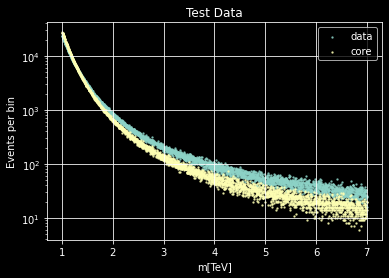

In [326]:
plt.yscale("log")
plt.title("Test Data")
plt.scatter(x_test[:y_test.shape[0],1],y_test,label="data",s=2,alpha=0.7)
plt.scatter(x_test[:y_test.shape[0],1],x_test[:,0],label="core",s=2,alpha=0.7)
plt.grid()
plt.xlabel("m[TeV]")
plt.ylabel("Events per bin")
plt.legend()
plt.show()

In [327]:
#import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
#os.environ["CUDA_VISIBLE_DEVICES"]="0";

In [334]:
def create_model(inx):
    # Create the model 
    model = keras.Sequential()
    model.add(keras.layers.Dense(units = 16, activation = 'linear', input_shape=[inx]))
    model.add(keras.layers.Dense(units = 64, activation = 'relu', kernel_regularizer='l1'))
    model.add(keras.layers.Dense(units = 128, activation = 'relu', kernel_regularizer='l1'))
    model.add(keras.layers.Dense(units = 128, activation = 'relu', kernel_regularizer='l1'))
    model.add(keras.layers.Dense(units = 64, activation = 'relu', kernel_regularizer='l1'))
    model.add(keras.layers.Dense(units = 1, activation = 'linear'))
    model.compile(loss='mse', optimizer="adam")

    # Display the model
    model.summary()

    return model

In [335]:
callbacks = [keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, 
                                           patience=15, verbose=0,
                                           mode='auto', baseline=None,
                                           restore_best_weights=True)]

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_127 (Dense)            (None, 16)                32        
_________________________________________________________________
dense_128 (Dense)            (None, 64)                1088      
_________________________________________________________________
dense_129 (Dense)            (None, 128)               8320      
_________________________________________________________________
dense_130 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_131 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_132 (Dense)            (None, 1)                 65        
Total params: 34,273
Trainable params: 34,273
Non-trainable params: 0
_________________________________________________

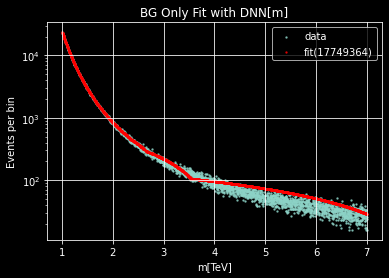

In [339]:
model_base = create_model(1)

model_base.fit(x_train[:,1], y_train, epochs=100, verbose=1, batch_size=32, callbacks=callbacks)

y_hat = model_base.predict(x_test[:,1])
mse = np.mean((y_hat - y_test)**2)
print(mse)

# Display the result
plt.title("BG Only Fit with DNN[m]")
plt.yscale("log")
plt.scatter(x_test[:y_test.shape[0],1],y_test,s=2,label="data",alpha=0.7)
#plt.scatter(x_test[:y_test.shape[0],1],x_test[:,0],s=2,label="core")
plt.scatter(x_test[:y_test.shape[0],1],y_hat,s=2,label="fit({})".format(int(mse)),color="red",alpha=0.7)
plt.grid()
plt.xlabel("m[TeV]")
plt.ylabel("Events per bin")
plt.legend()
plt.show()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_133 (Dense)            (None, 16)                32        
_________________________________________________________________
dense_134 (Dense)            (None, 64)                1088      
_________________________________________________________________
dense_135 (Dense)            (None, 128)               8320      
_________________________________________________________________
dense_136 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_137 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_138 (Dense)            (None, 1)                 65        
Total params: 34,273
Trainable params: 34,273
Non-trainable params: 0
_________________________________________________

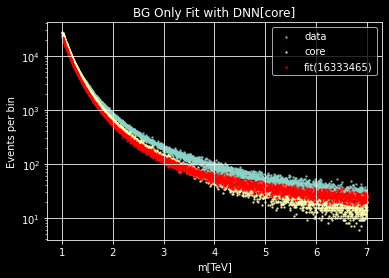

In [340]:
model_core1 = create_model(1)

model_core1.fit(x_train[:,0], y_train, epochs=100, verbose=1, batch_size=32, callbacks=callbacks)

y_hat = model_core1.predict(x_test[:,0])
mse = np.mean((y_hat - y_test)**2)
print(mse)

# Display the result
plt.title("BG Only Fit with DNN[core]")
plt.yscale("log")
plt.scatter(x_test[:y_test.shape[0],1],y_test,s=2,label="data",alpha=0.7)
plt.scatter(x_test[:y_test.shape[0],1],x_test[:,0],s=2,label="core",alpha=0.7)
plt.scatter(x_test[:y_test.shape[0],1],y_hat,s=2,label="fit({})".format(int(mse)),color="red",alpha=0.7)
plt.grid()
plt.xlabel("m[TeV]")
plt.ylabel("Events per bin")
plt.legend()
plt.show()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_139 (Dense)            (None, 16)                48        
_________________________________________________________________
dense_140 (Dense)            (None, 64)                1088      
_________________________________________________________________
dense_141 (Dense)            (None, 128)               8320      
_________________________________________________________________
dense_142 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_143 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_144 (Dense)            (None, 1)                 65        
Total params: 34,289
Trainable params: 34,289
Non-trainable params: 0
_________________________________________________

219/219 [==============================] - 0s 2ms/step - loss: 16830.0918
Epoch 83/100
219/219 [==============================] - 0s 2ms/step - loss: 17147.9746
Epoch 84/100
219/219 [==============================] - 0s 2ms/step - loss: 18080.5762
Epoch 85/100
219/219 [==============================] - 0s 2ms/step - loss: 18323.1543
Epoch 86/100
219/219 [==============================] - 0s 2ms/step - loss: 12415.1406
Epoch 87/100
219/219 [==============================] - 0s 2ms/step - loss: 36761.4453
Epoch 88/100
219/219 [==============================] - 0s 2ms/step - loss: 32939.8555
Epoch 89/100
219/219 [==============================] - 0s 2ms/step - loss: 15092.5293
Epoch 90/100
219/219 [==============================] - 0s 2ms/step - loss: 18112.2383
Epoch 91/100
219/219 [==============================] - 0s 2ms/step - loss: 12005.2002
Epoch 92/100
219/219 [==============================] - 0s 2ms/step - loss: 15923.0986
Epoch 93/100
219/219 [==============================] - 

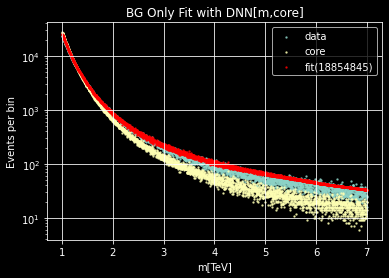

In [341]:
model_core2 = create_model(2)

model_core2.fit(x_train, y_train, epochs=100, verbose=1, batch_size=32, callbacks=callbacks)

y_hat = model_core2.predict(x_test)
mse = np.mean((y_hat - y_test)**2)
print(mse)

# Display the result
plt.title("BG Only Fit with DNN[m,core]")
plt.yscale("log")
plt.scatter(x_test[:y_test.shape[0],1],y_test,s=2,label="data",alpha=0.7)
plt.scatter(x_test[:y_test.shape[0],1],x_test[:,0],s=2,label="core",alpha=0.7)
plt.scatter(x_test[:y_test.shape[0],1],y_hat,s=2,label="fit({})".format(int(mse)),color="red",alpha=0.7)
plt.grid()
plt.xlabel("m[TeV]")
plt.ylabel("Events per bin")
plt.legend()
plt.show()

In [301]:
# Try LSTM
# create another sequece t-1
def look_back(X, i):
    n = X.shape[0]
    return X[i:], np.roll(X, i)[i:]

In [302]:
na1, na0 = look_back(na, 1)

In [303]:
print(na1, na0)

[23653. 23938. 23748. ...    36.    33.    37.] [23870. 23653. 23938. ...    27.    36.    33.]


In [304]:
def lstm_train_test_split(X, Y, test_size=0.3, t=1):
    assert X.shape == Y.shape
    idx = int(X.shape[0] * (1-test_size))
    lx_train, lx_test, ly_train, ly_test = X[:idx], X[idx:], Y[:idx], Y[idx:]
    return (lx_train.reshape(lx_train.size,t,1),
            lx_test.reshape(lx_test.size,t,1),
            ly_train.reshape(ly_train.size,t,1),
            ly_test.reshape(ly_test.size,t,1))

In [305]:
def create_LSTM(inx):
    # Create the model 
    model = keras.Sequential()
    model.add(keras.layers.LSTM(units = 16, activation = 'relu', 
                                return_sequences=True, input_shape=inx, kernel_regularizer='l1'))
    model.add(keras.layers.LSTM(units = 32, activation = 'relu', kernel_regularizer='l1'))
    model.add(keras.layers.Dense(units = 64, activation = 'relu', kernel_regularizer='l1'))
    model.add(keras.layers.Dense(units = 128, activation = 'relu', kernel_regularizer='l1'))
    model.add(keras.layers.Dense(units = 128, activation = 'relu', kernel_regularizer='l1'))
    model.add(keras.layers.Dense(units = 64, activation = 'relu', kernel_regularizer='l1'))
    model.add(keras.layers.Dense(units = 1, activation = 'linear'))
    model.compile(loss='mse', optimizer="adam")

    # Display the model
    model.summary()

    return model

In [306]:
lx_train, lx_test, ly_train, ly_test = lstm_train_test_split(na0, na1, test_size=0.3, t=1)
print(lx_train.shape, lx_test.shape, ly_train.shape, ly_test.shape)

base_lstm = create_LSTM((1,1))

callbacks = [keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, 
                                           patience=25, verbose=0,
                                           mode='auto', baseline=None,
                                           restore_best_weights=True)]

base_lstm.fit(lx_train, ly_train, epochs=100, verbose=1, batch_size=64, callbacks=callbacks)

ly_hat = base_lstm.predict(lx_test)
mse = np.mean((ly_hat - ly_test)**2)
print(mse)

(6999, 1, 1) (3000, 1, 1) (6999, 1, 1) (3000, 1, 1)
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 1, 16)             1152      
_________________________________________________________________
lstm_22 (LSTM)               (None, 32)                6272      
_________________________________________________________________
dense_83 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_84 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_85 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_86 (Dense)             (None, 64)                8256      
_________________________________________________________________
d

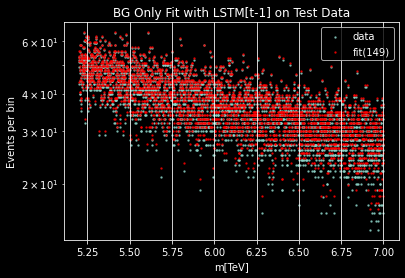

(10000,)
(9999, 1, 1)


In [307]:
# Display the result
plt.title("BG Only Fit with LSTM[t-1] on Test Data")
plt.yscale("log")
plt.scatter(binsa[-ly_test.shape[0]:],ly_test,s=2,label="data",alpha=0.7)
#plt.scatter(binsa[-ly_test.shape[0]:],lx_test[:,0],s=2,label="core",alpha=0.7)
plt.scatter(binsa[-ly_test.shape[0]:],ly_hat,s=2,label="fit({})".format(int(mse)),color="red",alpha=0.7)
plt.grid()
plt.xlabel("m[TeV]")
plt.ylabel("Events per bin")
plt.legend()
plt.show()

ly_train_hat = base_lstm.predict(lx_train)

print(binsa[:na.shape[0]].shape)
print(np.concatenate((ly_train,ly_test)).shape)

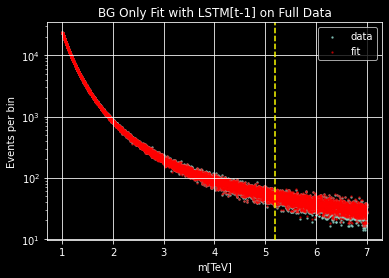

In [308]:
# Display the result
plt.title("BG Only Fit with LSTM[t-1] on Full Data")
plt.yscale("log")
plt.scatter(binsa[:na.shape[0]-1],np.concatenate((ly_train,ly_test)),s=2,label="data",alpha=0.7)
#plt.scatter(binsa[-ly_test.shape[0]:],lx_test[:,0],s=2,label="core",alpha=0.7)
plt.scatter(binsa[:na.shape[0]-1],np.concatenate((ly_train_hat,ly_hat)),s=2,label="fit",color="red",alpha=0.5)
plt.axvline(x=binsa[-ly_test.shape[0]], alpha=1, linestyle="--", c='yellow')
plt.grid()
plt.xlabel("m[TeV]")
plt.ylabel("Events per bin")
plt.legend()
plt.show()

In [318]:
# Try LSTM core - 1 -> data
nb1, nb0 = look_back(nb, 1)
print(nb1, nb0)

lx_train, lx_test, ly_train, ly_test = lstm_train_test_split(nb0, na1, test_size=0.3, t=1)
print(lx_train.shape, lx_test.shape, ly_train.shape, ly_test.shape)

base_core_lstm = create_LSTM((1,1))

callbacks = [keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, 
                                           patience=25, verbose=0,
                                           mode='auto', baseline=None,
                                           restore_best_weights=True)]

base_core_lstm.fit(lx_train, ly_train, epochs=100, verbose=1, batch_size=64, callbacks=callbacks)

ly_hat = base_core_lstm.predict(lx_test)
mse = np.mean((ly_hat - ly_test)**2)
print(mse)

[2.8190e+04 2.8107e+04 2.8165e+04 ... 1.4000e+01 1.0000e+01 2.3000e+01] [2.8329e+04 2.8190e+04 2.8107e+04 ... 1.5000e+01 1.4000e+01 1.0000e+01]
(6999, 1, 1) (3000, 1, 1) (6999, 1, 1) (3000, 1, 1)
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 1, 16)             1152      
_________________________________________________________________
lstm_28 (LSTM)               (None, 32)                6272      
_________________________________________________________________
dense_98 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_99 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_100 (Dense)            (None, 128)               16512     
_______________________________________________________

110/110 [==============================] - 1s 7ms/step - loss: 22702.6445
Epoch 75/100
110/110 [==============================] - 1s 7ms/step - loss: 33268.9961
Epoch 76/100
110/110 [==============================] - 1s 7ms/step - loss: 17304.4336
Epoch 77/100
110/110 [==============================] - 1s 7ms/step - loss: 17808.4336
Epoch 78/100
110/110 [==============================] - 1s 7ms/step - loss: 14329.7393
Epoch 79/100
110/110 [==============================] - 1s 7ms/step - loss: 12616.1426
Epoch 80/100
110/110 [==============================] - 1s 7ms/step - loss: 15603.9512
Epoch 81/100
110/110 [==============================] - 1s 7ms/step - loss: 14052.9463
Epoch 82/100
110/110 [==============================] - 1s 7ms/step - loss: 13932.3711
Epoch 83/100
110/110 [==============================] - 1s 7ms/step - loss: 13836.8477
Epoch 84/100
110/110 [==============================] - 1s 7ms/step - loss: 11866.1592
Epoch 85/100
110/110 [==============================] - 

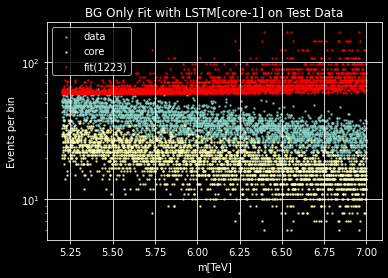

(10000,)
(9999, 1, 1)


In [319]:
# Display the result
plt.title("BG Only Fit with LSTM[core-1] on Test Data")
plt.yscale("log")
plt.scatter(binsa[-ly_test.shape[0]:],ly_test,s=2,label="data",alpha=0.7)
plt.scatter(binsa[-ly_test.shape[0]:],lx_test,s=2,label="core",alpha=0.7)
plt.scatter(binsa[-ly_test.shape[0]:],ly_hat,s=2,label="fit({})".format(int(mse)),color="red",alpha=0.7)
plt.grid()
plt.xlabel("m[TeV]")
plt.ylabel("Events per bin")
plt.legend()
plt.show()

ly_train_hat = base_lstm.predict(lx_train)

print(binsa[:na.shape[0]].shape)
print(np.concatenate((ly_train,ly_test)).shape)

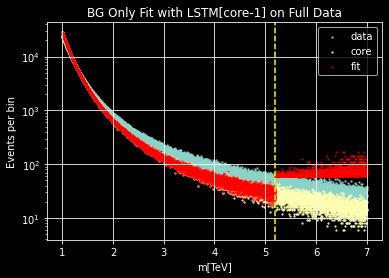

In [320]:
# Display the result
plt.title("BG Only Fit with LSTM[core-1] on Full Data")
plt.yscale("log")
plt.scatter(binsa[:na.shape[0]-1],np.concatenate((ly_train,ly_test)),s=2,label="data",alpha=0.7)
plt.scatter(binsa[:na.shape[0]-1],np.concatenate((lx_train,lx_test)),s=2,label="core",alpha=0.7)
plt.scatter(binsa[:na.shape[0]-1],np.concatenate((ly_train_hat,ly_hat)),s=2,label="fit",color="red",alpha=0.5)
plt.axvline(x=binsa[-ly_test.shape[0]], alpha=1, linestyle="--", c='yellow')
plt.grid()
plt.xlabel("m[TeV]")
plt.ylabel("Events per bin")
plt.legend()
plt.show()

In [ ]:
# LSTM with data - 1 + m

## Inject Signal

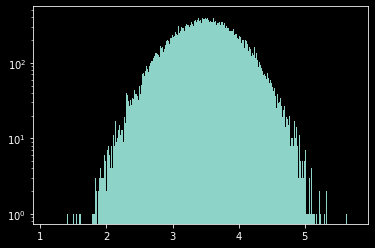

In [125]:
# add a gaussian signal at 3.5 TeV
# 100k signal vs 10m bg
sig_samples = gauss(300000, mean=3.5, std=0.5)
(ns, binss, patchess) = plt.hist(sig_samples, log=True, bins=3000)
plt.show()

In [205]:
print(ns.shape)

(3000,)


In [206]:
print(x_test.shape)
print(y_test.shape)

(3000, 2)
(3000,)


In [208]:
inds = np.digitize(x_test[:,1],np.linspace(x_test[:,1].min(),x_test[:,1].max(),2999))
indss = np.digitize(binss[:ns.shape[0]],np.linspace(x_test[:,1].min(),x_test[:,1].max(),2999))

In [1]:
# print(binss[1000:2000])
# print(indss[1000:2000])
# print(ns[1000:2000])

In [241]:
y_test_all = y_test[inds] + ns[inds]

In [242]:
print(y_test_all)

[  58. 1225.  204. ...  121.   84.  246.]


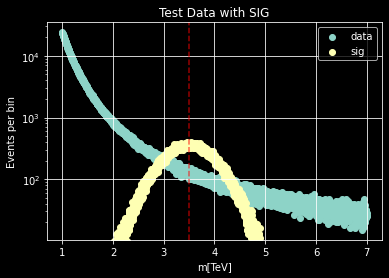

In [243]:
plt.yscale("log")
plt.title("Test Data with SIG")
plt.scatter(x_test[:y_test.shape[0],1],y_test,label="data")
plt.scatter(binss[:ns.shape[0]],ns,label="sig")
plt.axvline(x=3.5, alpha=0.6, linestyle="--", c='r')
#plt.scatter(x_test[:y_test.shape[0],1],x_test[:,0],label="core")
plt.grid()
plt.xlabel("m[TeV]")
plt.ylabel("Events per bin")
plt.legend()
plt.show()

In [244]:
print(y_test_all.shape)

(3000,)


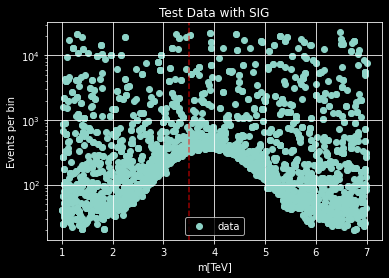

In [246]:
plt.yscale("log")
plt.title("Test Data with SIG")
plt.scatter(x_test[inds,1],y_test_all[inds],label="data")
#plt.scatter(binss[inds],ns[inds],label="data")
plt.axvline(x=3.5, alpha=0.6, linestyle="--", c='r')
#plt.scatter(x_test[:y_test.shape[0],1],x_test[:,0],label="core")
plt.grid()
plt.xlabel("m[TeV]")
plt.ylabel("Events per bin")
plt.legend()
plt.show()

In [229]:
all_samples = np.concatenate((samplesa, sig_samples))

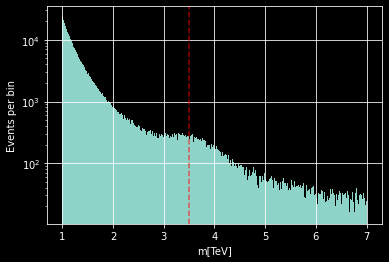

In [230]:
(n, bins, patches) = plt.hist(all_samples, log=True, bins=10000)
plt.grid()
plt.axvline(x=3.5, alpha=0.6, linestyle="--", c='r')
plt.xlabel("m[TeV]")
plt.ylabel("Events per bin")
plt.show()

In [232]:
y_hat = model_base.predict(bins)

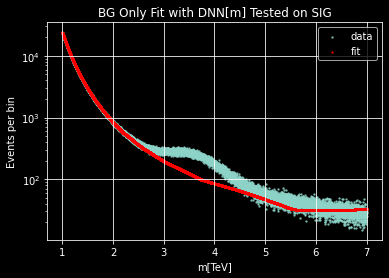

In [233]:
# Display the result
plt.title("BG Only Fit with DNN[m] Tested on SIG")
plt.yscale("log")
plt.scatter(bins[:n.shape[0]],n,s=2,label="data",alpha=0.7)
#plt.scatter(x_test[:y_test.shape[0],1],x_test[:,0],s=2,label="core")
plt.scatter(bins[:y_hat.shape[0]],y_hat,s=2,label="fit",color="red",alpha=0.7)
plt.grid()
plt.xlabel("m[TeV]")
plt.ylabel("Events per bin")
plt.legend()
plt.show()